# Step 1: Getting the IG posts

```
conda create -n depths
mamba install -n depths -c conda-forge Jupyter pandas numpy scipy matplotlib
conda activate depths  # I used this kernel from my VSCode Jupyter kernel selector
```

First use `scrape.js` to get the post URLs and datetimes, and save the results using the below code block.

And then open it in excel to manually annotate, saving it as `./data/data2.csv`. This is very subjective. Sometimes the article is clearly linked. Sometimes the article is implied with a little bit of googling. Sometimes it's an album with a ton of articles. It's pretty subjective how I chose to handle some of these; my rule of thumb was that I recorded article titles for any post where I felt like a normal person might Google a snipped of the post and find the relevant article. So for posts that are just context-free image dumps, I usually would just annotate it as `NA` because most people probably wouldn't try to google that. But otherwise, I  tried to include the relevant article(s) for each IG post whenever possible.

NOTE: Excel will famously mess with your data! Especially if your cell looks anything like a number or a date. Probably need to manually adjust this using a plaintext editor for certain entries.

In [19]:
import pandas as pd

# I scraped multiple different times into different JSON files
# This is just how we make sure they're all in the right chronological order

data_files = []
for i in ['', '2']:
  data_files.append(pd.read_json(f'./data/data{i}.json').T)

full_data = (pd.concat(data_files)
             .reset_index()
             .sort_values(['date', 'index'], 
                          ascending=[False, True]))
full_data = (full_data
             .drop_duplicates('ig_url')
             .reset_index()[['ig_url', 'date']])
print(f'{full_data.shape[0]} total posts.')

# Commented out to avoid accidentally overwriting
# full_data.to_csv('./data/data.csv')

1081 total posts.


# Step 2: Getting the Wikipedia viewership numbers

In [24]:
import pandas as pd
import numpy as np
from urllib.parse import quote
import matplotlib.pyplot as plt
import datetime
import requests
import os
import time
import sqlite3
import scipy

class DB():
    def __init__(self, db_path='./data/db.sql'):
        self.db_path = db_path

        with sqlite3.connect(self.db_path) as con:
                cur = con.cursor()
                cur.execute('CREATE TABLE IF NOT EXISTS '
                            'pageviews(article, ig_post, rel_date, date, views)')
                con.commit()

        if not os.path.isfile(self.db_path):
            print(f'Created db at {self.db_path}')
        else:
            print(f'Database at {self.db_path} already exists.')
        
    def save_to_db(self, df):
        data = []
        for _, row in df.iterrows():
            data.append((row.Article, # Shut up I don't care if it's redundant
                        row.IG_post, 
                        row.Rel_Date, 
                        row.Date, 
                        row.Views))
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            cur.executemany("INSERT INTO pageviews VALUES(?, ?, ?, ?, ?)", data)
            con.commit()
        print(f'Successfully saved data for article {data[0][0]}')

    def article_in_db(self, article, date):
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            qry = 'SELECT COUNT(*) FROM pageviews WHERE article = ? AND date = ? AND rel_date = 0'
            cur.execute(qry, (article, date))
            count = cur.fetchone()[0]
        return count > 0
    
    def read_from_db(self):
        qry = 'SELECT article, ig_post, rel_date, date, views FROM pageviews'
        res = self.execute_qry(qry)
    
        out = pd.DataFrame(res)
        out.columns = ['Article', 'IG_post', 'Rel_Date', 'Date', 'Views']
        return out
    
    def execute_qry(self, qry, params=None):
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            if params is None:
                cur.execute(qry)
            else:
                cur.execute(qry, params)
            res = cur.fetchall()
        return res

def title_to_wikipedia_enc(title):
    encoded_title = quote(title.replace(' ', '_'), safe='')
    return encoded_title

def fill_missing_values(df, day_0):
    min_rel_date = df['Rel_Date'].min()
    max_rel_date = df['Rel_Date'].max()

    all_rel_dates = list(range(min_rel_date, max_rel_date + 1))
    if all(rd in df.Rel_Date for rd in all_rel_dates):  # Do nothing if df is complete
        return df
    else:
        complete_rel_dates = pd.DataFrame({'Rel_Date': all_rel_dates})
        complete_rel_dates['Article'] = df.Article[0]
        complete_rel_dates['IG_post'] = df.IG_post[0]
        complete_rel_dates['Date'] = ((day_0 + 
                                       pd.to_timedelta(complete_rel_dates['Rel_Date'], unit='D'))
                                       .dt.strftime('%Y-%m-%d'))
        
        view_values = df[['Date', 'Views']]
        res = pd.merge(complete_rel_dates, view_values, on='Date', how='left').fillna(0)
        res = res[['Article', 'IG_post', 'Rel_Date', 'Date', 'Views']]
        return res


def get_pageview_numbers(article, d0, ig_url, db, delta=31):
    article_enc = title_to_wikipedia_enc(article)

    day_0 = datetime.datetime.strptime(d0, '%Y-%m-%d')
    api_date_format = '%Y%m%d'
    day_start = (day_0 + datetime.timedelta(days=-delta)).strftime(api_date_format)
    day_end = (day_0 + datetime.timedelta(days=delta)).strftime(api_date_format)

    url = (f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article'
           f'/en.wikipedia/all-access/all-agents/'
           f'{article_enc}/daily/{day_start}00/{day_end}00')
    print(url)  # I will never apologize for print logging/debugging
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        pageviews_data = response.json()

        dates = []
        rel_dates = []
        views = []
        for item in pageviews_data['items']:
            cur_day = datetime.datetime.strptime(item['timestamp'], 
                                                  '%Y%m%d%S')
            rel_date = (cur_day - day_0).days

            cur_day_fmt = cur_day.strftime('%Y-%m-%d')
            cur_views = int(item['views'])
            
            dates.append(cur_day_fmt)
            rel_dates.append(rel_date)
            views.append(cur_views)

        out = pd.DataFrame({'Article': [article] * len(dates), 
                            'IG_post': [ig_url] * len(dates),
                            'Rel_Date': rel_dates,
                            'Date': dates, 
                            'Views': views})
        
        out = fill_missing_values(out, day_0)
        db.save_to_db(out)
    else:
        print(f'Error for article {article}: {response.status_code}')
        out = pd.DataFrame({'Article': [], 
                            'IG_post': [],
                            'Rel_Date': [],
                            'Date': [], 
                            'Views': []})
    
    return out


# data2.csv has the manual annotation and can't get overwritten by accident
data = pd.read_csv('./data/data2.csv').dropna()
data.date = pd.to_datetime(data.date).dt.strftime('%Y-%m-%d')
data.columns = ['ig_index', 'ig_url', 'date', 'title']

In [26]:
my_db = DB(db_path='./data/db2.sql')

for i, row in data.iterrows():
    cur_scrape = f'{row.title} for date {row.date}'
    if my_db.article_in_db(row.title, row.date):
        print(f'Skipping: {cur_scrape}')
        next
    else:
        print(f'Scraping: {cur_scrape}')
        try:
            get_pageview_numbers(article=row.title, d0=row.date, 
                                    ig_url=row.ig_url, db=my_db, delta=31)
        except ConnectionError as e:
            print(f'Failed: {cur_scrape}')
        time.sleep(3)
        
        


Database at ./data/db2.sql already exists.
Skipping: 1956 Olympic flame hoax for date 2024-08-04
Skipping: Eremina desertorum for date 2024-07-31
Skipping: I'm Coming Out for date 2024-07-21
Skipping: Puppy pregnancy syndrome for date 2024-07-17
Skipping: Meow Mix for date 2024-07-17
Scraping: Nowhere  girls for date 2024-06-21
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Nowhere__girls/daily/2024052100/2024072200
Error for article Nowhere  girls: 404
Skipping: Museum fatigue for date 2024-06-21
Skipping: Mansfield Smith-Cumming for date 2024-06-11
Skipping: Wrocław Dwarfs for date 2024-05-31
Skipping: Thinking about the immortality of the crab for date 2024-05-27
Skipping: Where in the World Is Osama bin Laden? for date 2024-05-24
Skipping: Number 16 (spider) for date 2024-05-22
Skipping: List of Czech inventions and discoveries for date 2024-05-16
Skipping: List of long marriages for date 2024-05-15
Skipping: Drake–Kendrick Lamar 

In [27]:
################################################################################
# Load results from db
full_results = pd.DataFrame(my_db.read_from_db())
full_results['day_0'] = ((pd.to_datetime(full_results.Date) - 
                          pd.to_timedelta(full_results.Rel_Date, unit='D'))
                         .dt.strftime('%Y-%m-%d'))

pd.options.mode.chained_assignment = None  # Remove all the warning messages
subsets = []
for article, day_zero in set(zip(data.title, data.date)):
    subset = full_results[(full_results.Article == article) & 
                          (full_results.day_0 == day_zero)]
    try:
        reference_point = int(subset[subset.Rel_Date == -1].Views)
        rel_views = subset['Views'] / reference_point
        subset.loc[:, 'Rel_Views'] = rel_views
        subsets.append(subset)
    except TypeError:
        print(f'Not working for article: {article}')
        
################################################################################   
# Aggregation

# https://stackoverflow.com/a/17578653/15014819
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'p{:02.0f}'.format(n*100)
    return percentile_

combined = pd.concat(subsets)
aggfuns = ['mean', 'std', 
           percentile(0.10),
           percentile(.25), 
           percentile(.50), 
           percentile(.75),
           percentile(0.90)]
summary = (combined.replace([np.inf, -np.inf], np.nan)
           .dropna().groupby('Rel_Date')
           .agg({'Rel_Views': aggfuns,
                 'Views': aggfuns}))



Not working for article: No Way To Prevent This,' Says Only Nation Where This Regularly Happens
Not working for article: India–Bangladesh enclaves 
Not working for article: Nowhere  girls
Not working for article: Wikipedia Star Trek Into Darkness debate
Not working for article: Crème Puff (cat)
Not working for article: Anglo-Zanzibar war
Not working for article: #NAME?
Not working for article: I Am rich
Not working for article: dril
Not working for article: Athletics at the 1904 Summer Olympics – men's marathon
Not working for article: User:Asticky
Not working for article: UConn–UMass rivalry
Not working for article: Category:Animals with paper party hats
Not working for article: Dice by number of sides
Not working for article: National Stupid Day
Not working for article: 45400
Not working for article: Roger …felde
Not working for article: Terms describing gay men


# Step 3: Analysis and Visualization

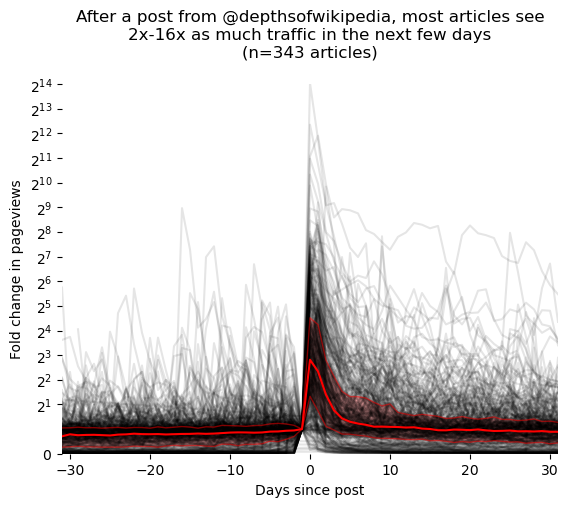

In [28]:
################################################################################
# Actual viz now

(fig, ax) = plt.subplots(1,1)
for article in combined.Article.unique():
    sub = combined[combined.Article == article]
    ax.plot(sub.Rel_Date, sub.Rel_Views, alpha=0.1, c='black')

# Plot trendline for mean
# avg = summary.Rel_Views['mean']
# ax.plot(summary.index, avg, c='green', lw=2, ls=':')

# Plot trendline for q25, q50, q75
ax.plot(summary.index, summary.Rel_Views['p50'], c='red', lw=1.5, 
        ls='-')
ax.plot(summary.index, summary.Rel_Views['p25'], c='red', lw=1, 
        ls='-', alpha=0.5)
ax.plot(summary.index, summary.Rel_Views['p75'], c='red', lw=1, 
        ls='-', alpha=0.5)
ax.fill_between(summary.index, 
                summary.Rel_Views['p25'], 
                summary.Rel_Views['p75'], 
                facecolor='red', alpha=0.3)

period = 31
ymin = 0
ymax = combined.replace([np.inf, -np.inf], np.nan).dropna().Rel_Views.max()
ax.set_xlim(-period, period)
ax.set_ylim(ymin, 2**14)
ax.set_frame_on(False)
ax.set_yscale('symlog', base=2)
ax.set_xlabel('Days since post')
ax.set_ylabel('Fold change in pageviews')
ax.set_title(f'After a post from @depthsofwikipedia, most articles see'
             f'\n2x-16x as much traffic in the next few days'
             f'\n(n={combined.Article.unique().size} articles)', pad=20)


fig.show()

In [29]:
# Saying that most articles see 2x-16x as much traffic is actually somewhat
# underselling it, at least at the time of writing this comment
pd.set_option('display.max_rows', 64)
summary

Rel_Views                                                       \
                mean         std       p10       p25       p50        p75   
Rel_Date                                                                    
-31         0.974718    3.022036  0.044017  0.265013  0.706149   1.047900   
-30         0.800449    0.923684  0.046195  0.280323  0.788136   1.050725   
-29         0.828424    1.085141  0.041316  0.301796  0.750000   1.076375   
-28         0.841508    0.878847  0.042422  0.277047  0.762471   1.052520   
-27         0.808705    0.736084  0.041183  0.273893  0.766862   1.057973   
-26         0.842108    0.974696  0.041275  0.265860  0.753969   1.038055   
-25         0.813568    1.001344  0.041003  0.264935  0.740084   1.056259   
-24         0.879300    1.563461  0.035806  0.266170  0.776428   1.068912   
-23         0.887654    2.321286  0.040976  0.275367  0.785630   1.041835   
-22         0.968227    2.889848  0.040081  0.305063  0.813008   1.065942   
-21         0.862941    1.081974  0.042814  0.293627  0.795610   1.062473   
-20         0.864017    1.026191  0.044275  0.291072  0.791935   1.036802   
-19         0.861888    1.041979  0.043799  0.265143  0.797606   1.091330   
-18         0.798011    0.668814  0.047121  0.311765  0.782213   1.049613   
-17         0.856009    0.896633  0.049782  0.337579  0.792408   1.076113   
-16         2.374882   26.831318  0.041003  0.319087  0.802711   1.103816   
-15         1.434945    8.711627  0.046354  0.330764  0.805061   1.081476   
-14         1.056009    2.711527  0.052357  0.332817  0.818813   1.036532   
-13         1.316935    6.908173  0.048158  0.307692  0.807143   1.093023   
-12         1.558116    9.640630  0.045390  0.296252  0.817524   1.080961   
-11         1.178829    2.834731  0.054439  0.385134  0.837170   1.149160   
-10         1.046103    1.601241  0.045880  0.380006  0.858339   1.140263   
-9          0.928021    0.911377  0.050064  0.325397  0.865922   1.130027   
-8          1.188253    3.394266  0.045824  0.382277  0.862979   1.111629   
-7          1.348329    5.771470  0.055151  0.376021  0.853964   1.140613   
-6          1.298810    3.471181  0.061250  0.402440  0.863053   1.153608   
-5          1.332663    2.824356  0.058494  0.506403  0.897898   1.210349   
-4          1.198463    2.415628  0.049231  0.487652  0.903563   1.232929   
-3          1.261832    2.562670  0.068651  0.581531  0.931409   1.208661   
-2          1.056906    1.063071  0.162849  0.701055  0.944365   1.152987   
-1          1.000000    0.000000  1.000000  1.000000  1.000000   1.000000   
 0        107.858961  955.371954  1.174445  2.516199  7.037102  22.891537   
 1         54.793430  299.688920  0.903274  1.738411  5.065574  18.924242   
 2         18.413337   84.948758  0.433799  1.108567  2.627641   6.923077   
 3         10.146911   42.815229  0.324286  0.961147  1.760448   4.413352   
 4          6.796309   33.160884  0.237799  0.796908  1.432802   2.894584   
 5          5.773398   28.686111  0.202797  0.791847  1.297479   2.495434   
 6          4.737681   24.927505  0.152514  0.748188  1.223529   2.493048   
 7          4.196757   18.553875  0.148726  0.711183  1.173393   2.393213   
 8          3.224624   14.835478  0.137186  0.644928  1.097222   2.119048   
 9          3.963296   18.906923  0.116530  0.620253  1.100000   1.942623   
 10         2.910543    9.925059  0.096626  0.616608  1.090632   2.028986   
 11         2.546570   12.371660  0.084474  0.603340  1.083796   1.676471   
 12         2.581099   13.829055  0.088337  0.576087  1.063291   1.608696   
 13         2.822786   18.044339  0.110800  0.568783  1.073851   1.549139   
 14         2.656247   17.185956  0.082464  0.591340  1.020266   1.596593   
 15         2.433493   15.415698  0.080703  0.526232  1.003586   1.562349   
 16         2.476356   16.450287  0.081635  0.534370  0.953416   1.517832   
 17         2.392154    9.170608  0.073994  0.504746  0.949623   1.432889   
 18    

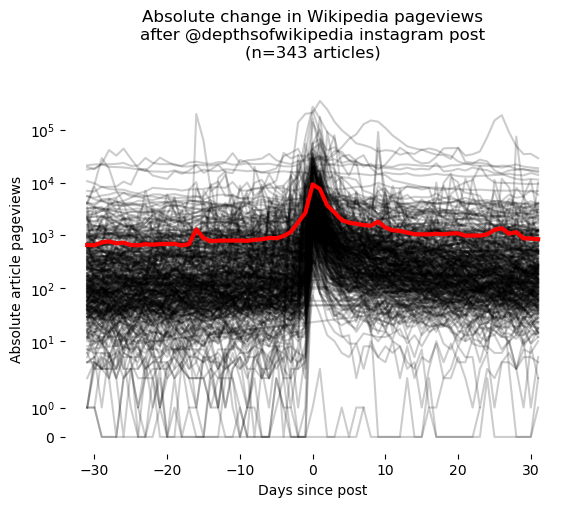

In [30]:
(fig, ax) = plt.subplots(1,1)

avg = summary.Views['mean']
sd = summary.Views['std']
lower = avg - sd
upper = avg + sd
ymin = 0
ymax = combined.replace([np.inf, -np.inf], np.nan).dropna().Rel_Views.max()

for article in combined.Article.unique():
    sub = combined[combined.Article == article]
    ax.plot(sub.Rel_Date, sub.Views, alpha=0.2, c='black')
ax.plot(summary.index, avg, c='red', lw=3, ls='-')
ax.set_yscale('symlog')
ax.set_frame_on(False)
ax.set_xlabel('Days since post')
ax.set_ylabel('Absolute article pageviews')
ax.set_title(f'Absolute change in Wikipedia pageviews'
             f'\nafter @depthsofwikipedia instagram post'
             f'\n(n={combined.Article.unique().size} articles)', pad=20)

fig.show()

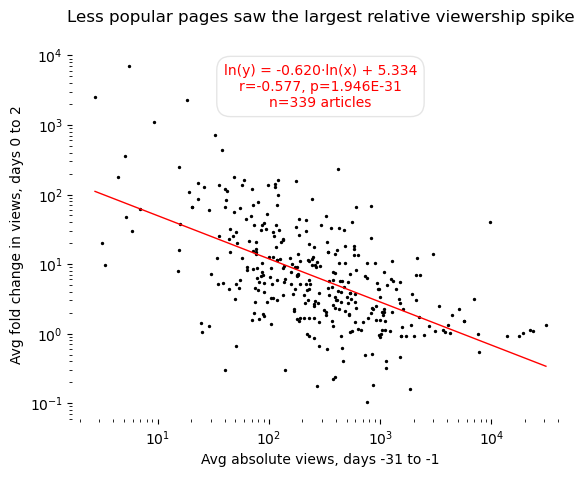

In [31]:
avg_before = (combined[combined.Rel_Date.between(-31, -1)]
              .groupby('Article')
              .agg({'Views': ['mean', 'std'], 
                    'Rel_Views': ['mean', 'std']}))
avg_peak = (combined[combined.Rel_Date.between(0,2)]
            .groupby('Article')
            .agg({'Views': ['mean', 'std'], 
                  'Rel_Views': ['mean', 'std']}))

assert all(avg_before.index == avg_peak.index)

# Regression line
valid_pages = avg_peak.index[~np.isnan(avg_peak.Rel_Views['mean']) & 
                             ~np.isinf(avg_peak.Rel_Views['mean'])]
res = scipy.stats.linregress(np.log(avg_before.loc[valid_pages,:].Views['mean']), 
                             np.log(avg_peak.loc[valid_pages,:].Rel_Views['mean']))
min_x = avg_before.loc[valid_pages,:].Views['mean'].min()
max_x = avg_before.loc[valid_pages,:].Views['mean'].max()

x_reg = np.arange(min_x, max_x, 1)
y_reg = np.exp(res.slope * np.log(x_reg) + res.intercept)
eqn = (f'ln(y) = {res.slope:.3f}·ln(x) + {res.intercept:.3f}'
       f'\nr={res.rvalue:.3f}, p={res.pvalue:.3E}'
       f'\nn={len(valid_pages)} articles' )


(fig, ax) = plt.subplots(1,1)
ax.scatter(avg_before.Views['mean'], avg_peak.Rel_Views['mean'], c='black', s=2)
ax.plot(x_reg, y_reg, c='red', ls='-', lw=1)
ax.text(0.5, 0.9, eqn, c='red', 
        transform = ax.transAxes, 
        horizontalalignment='center',
        verticalalignment='center',
        bbox=dict(boxstyle='round, rounding_size=1, pad=0.5', 
                  facecolor='white', alpha=0.1))


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlabel('Avg absolute views, days -31 to -1')
ax.set_ylabel('Avg fold change in views, days 0 to 2')
ax.set_frame_on(False)
ax.set_title('Less popular pages saw the largest relative viewership spike', pad=20)



fig.show()